# Authors

Yusuf Olodo and Carlos Cutillas

# Business problem

A new movie studio has approached our data science company and they are interested in the knowing how the movie industry works and what path to take when deciding their business problems.
1. They are interested in knowing whether there is a difference in the budget and the profit made for both Romance and Action movies genre
2. They are interested in knowing whether there is a difference in the budget and the profit made for movies in the 50s and 60s compared to the 2000s and 2010s

# Analysis 

## Data importing and cleaning 

In [90]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import random
import scipy.stats as stats
import re
from statsmodels.stats.power import TTestIndPower
power = TTestIndPower()

In [2]:
data = pd.read_csv('movies_last.csv')

In [3]:
data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace = True)

In [4]:
# Importing function for data cleaning .py file 
from data_preparing import get_decade

In [5]:
data['all_years'] = data['all_years'].apply(lambda x: re.sub('[^0-9]','', x))

data['all_genres'] = data['all_genres'].apply(lambda x: x[1:])

data['all_gross'] = data['all_gross'].apply(lambda x: x.replace(',',''))
data['all_gross'] = data['all_gross'].apply(lambda x:  int(x) if x != 'no' else 0)

data['all_scores'] = data['all_scores'].apply(lambda x: x.replace('.',''))
data['all_scores'] = data['all_scores'].apply(lambda x: int(x) if x != 'NO' else 0)

data['all_meta'] = data['all_meta'].apply(lambda x: int(x.replace('.','')) if x != 'no' else 0)


data['all_years'] = data['all_years'].apply(lambda x: int(x))

data['dec'] = data['all_years'].apply(lambda x: int(str(x)[2]))
data['decade'] = data['dec'].apply(lambda x: get_decade(x))

In [6]:
del data['dec']

### Importing external csv to get the budget 

In [7]:
movies_metadata = pd.read_csv('movies_metadata.csv')

/Users/carloscutillas/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
budget_and_id = movies_metadata[['budget', 'imdb_id']]

###  Importing external csv to get CPI inflation index 

In [9]:
inflation = pd.read_csv('https://pkgstore.datahub.io/core/cpi-us/cpiai_csv/data/b17bfacbda3c08e51cd13fe544b8fca4/cpiai_csv.csv')

### Cleaning new merges 

In [10]:
inflation['Date'] = inflation['Date'].apply(lambda x: x[:4]) 

inflation['Date'] = inflation['Date'].astype(int)

In [11]:
inf = inflation.groupby('Date').mean().reset_index(level= 0)

### Creating a dataframe with all the data together 

In [12]:
all_data = pd.merge(data, budget_and_id,how='left', left_on='id', right_on='imdb_id')

In [13]:
all_data.dropna(inplace=True)

In [14]:
all_data['budget'] = all_data['budget'].astype(int)
all_data['genre_bis'] = all_data['all_genres'].apply(lambda x: 'Action' if 'Action' in x
                                                     else ('Romance' if 'Romance' in x else 'no') 
                                                    )

In [15]:
all_data['profit'] = all_data['all_gross'] - all_data['budget']

### Merging inflation

In [16]:
data_with_inflation = pd.merge(all_data, inf,how='left', left_on='all_years', right_on='Date')

### Cleaning data with inflation 

In [17]:
del data_with_inflation['Inflation']

In [18]:
from data_preparing import get_last_years_inflation

In [19]:
data_with_inflation['Index_all'] = data_with_inflation['all_years'].apply(lambda x: get_last_years_inflation(x) )
data_with_inflation['Index_all'] = data_with_inflation['Index_all'].astype(str)

data_with_inflation['Index'] = data_with_inflation['Index'].astype(str)


data_with_inflation['Index_all_years'] = data_with_inflation.Index.fillna('') + data_with_inflation.Index_all.fillna('')

# data_with_inflation['Index_all_years'] = data_with_inflation['Index_all'].combine_first(data_with_inflation['Index'])

data_with_inflation['Index_all_years'] = data_with_inflation['Index_all_years'].apply(
    lambda x: x.lstrip('nan').rstrip('nan'))


In [20]:
del data_with_inflation['Index_all']
del data_with_inflation['Index']
del data_with_inflation['Date']


### Adjusting monetary units to inflation 

In [21]:
#  Re converting stringg to integer on index 

data_with_inflation['Index_all_years'] = data_with_inflation['Index_all_years'].astype(float)

In [22]:
data_with_inflation['budget_adjusted'] = (data_with_inflation['budget'] / data_with_inflation['Index_all_years'])*100

data_with_inflation['gross_adjusted'] = (data_with_inflation['all_gross'] / data_with_inflation['Index_all_years'])*100



In [23]:
data_with_inflation['profit_adjusted'] =  data_with_inflation['gross_adjusted'] - data_with_inflation['budget_adjusted'] 

### Exporting to csv (commented out in order to not eport it each time notebook is run)

In [24]:
# data_for_budget = all_data[all_data['budget'] > 0]

In [25]:
# data_for_budget.to_csv('movies_for_budget', encoding='utf-8')
# all_data.to_csv('movies_all', encoding='utf-8')

In [26]:
# data_with_inflation.to_csv('data_adjusted_to_inflation.csv')

## Hypothesis testing 

In [27]:
data_with_inflation = pd.read_csv('data_adjusted_to_inflation.csv')
data_for_ht = data_with_inflation.replace(0,data_with_inflation.median())

### H1 - 50's and 60's movies made more profit than movies nowadays

In [91]:
fifth_movies = list((data_for_ht[(data_for_ht['decade'] == "50s")|(data_for_ht['decade'] == "60s")]['profit_adjusted']))
now_movies = list((data_for_ht[(data_for_ht['decade']== "00s")|(data_for_ht['decade'] == "10s")]['profit_adjusted']))

#### Power analysis to determine sample size

In [93]:
number_of_samples = []
for i in [0.2, 0.25, 0.3, 0.35, 0.40, 0.45, 0.50, 0.60, 0.70, 0.80]:
    number_of_samples.append(power.solve_power(effect_size= i, alpha=0.05, power=0.8))

"Number of samples =  {} when alpha is: {},and power is: {}".format(number_of_samples, 0.05, 0.8)

'Number of samples =  [393.4056989990335, 252.12750515434277, 175.38467227482232, 129.11207873406047, 99.08032683981143, 78.49161726401, 63.765611775409525, 44.58579025908018, 33.02456951586263, 25.52457250047935] when alpha is: 0.05,and power is: 0.8'

#### Getting 2 samples of equal size 

In [29]:
fifth_movies_sample = random.sample(fifth_movies, 190)
now_movies_sample = random.sample(now_movies, 190)

#### Variance and mean of the samples 

In [30]:
print("The variance for the movies on 50s/60s is: {}".format(np.var(fifth_movies_sample)))
print("The std for the movies on 50s/60s is: {}".format(np.std(fifth_movies_sample)))
print("The mean for the movies on 50s/60s is: {}".format(np.mean(fifth_movies_sample)))

print('===============')

print("The variance for the movies nowadays is: {}".format(np.var(now_movies_sample)))
print("The std for the movies on nowadays is: {}".format(np.std(now_movies_sample)))
print("The mean for the movies on nowadays is: {}".format(np.mean(now_movies_sample)))



The variance for the movies on 50s/60s is: 6921459556396927.0
The std for the movies on 50s/60s is: 83195309.70191124
The mean for the movies on 50s/60s is: 76493573.67875181
The variance for the movies nowadays is: 595329980186541.9
The std for the movies on nowadays is: 24399384.83213341
The mean for the movies on nowadays is: 6396550.18820797


#### Normality test for samples 

In [31]:
stats.normaltest(now_movies_sample)

NormaltestResult(statistic=103.4699895166049, pvalue=3.402336428802614e-23)

In [32]:
stats.normaltest(fifth_movies_sample)

NormaltestResult(statistic=114.56707144675849, pvalue=1.3245749313916394e-25)

#### Plotting the distribution for both samples

Text(0, 0.5, 'Probability')

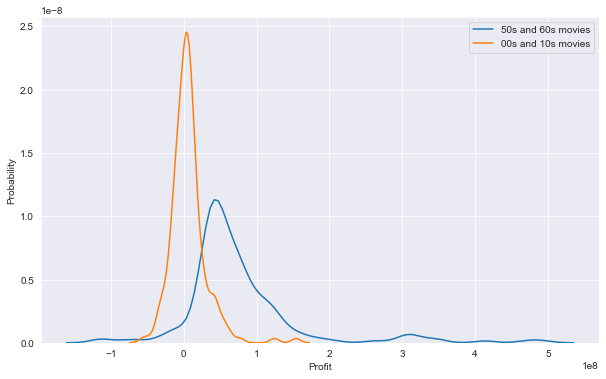

In [33]:
plt.figure(figsize=(10,6))
sns.distplot(fifth_movies_sample, label='50s and 60s movies', hist= False)
sns.distplot(now_movies_sample, label='00s and 10s movies', hist=False)

plt.xlabel('Profit')
plt.ylabel('Probability')

#### Difference between distribution means

In [34]:
diff_means = np.mean(fifth_movies_sample) - np.mean(now_movies_sample)
print("The difference between means is {}".format(diff_means))

The difference between means is 70097023.49054384


#### T-statistic

In [35]:
## Importing function from .py file where we stored them 
from hyp_testing_functions import pooled_variance, tstatistic
from ht_visualizations import visualize_t
 

In [36]:

t_stat = tstatistic(fifth_movies_sample, now_movies_sample)
print("T-Statistic is: {}".format(t_stat))

T-Statistic is: 11.144489573435894


In [37]:
import scipy.stats
# import stats.t
from scipy import stats

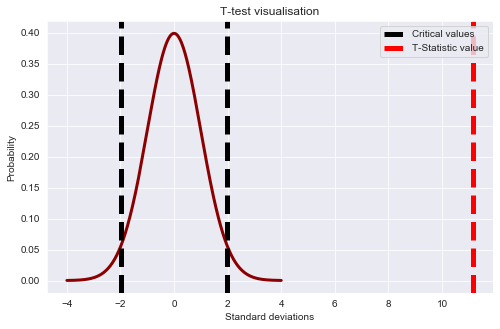

In [38]:

def visualize_t(t_stat, n_control, n_experimental):
    from matplotlib import pyplot as plt 

    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()

    xs = np.linspace(4, -4, 500)

    # use stats.t.ppf to get critical value. For alpha = 0.05 and two tailed test
    crit = stats.t.ppf(1-0.025, (n_control+n_experimental-2))
    
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(crit, color='black', linestyle='--', lw=5, label='Critical values')
    ax.axvline(-crit, color='black', linestyle='--', lw=5)
    ax.axvline(t_stat, color='red', linestyle='--', lw=5, label="T-Statistic value")
    
    plt.title('T-test visualisation')
    plt.legend(loc='best')
    plt.xlabel('Standard deviations')
    plt.ylabel('Probability')
    plt.show()
    return None
n_fifth = len(fifth_movies_sample)
n_now = len(now_movies_sample)
visualize_t(t_stat, n_fifth, n_now)



#### Getting p-value

In [39]:
lower_tail = stats.t.cdf(-t_stat, (190+190-2), 0, 1)
# Upper tail comulative density function returns area under upper tail curve
upper_tail = 1. - stats.t.cdf(t_stat, (190+190-2), 0, 1)

p_value = lower_tail+upper_tail
print(p_value)

1.9595353553602931e-25


In [40]:
stats.ttest_ind(fifth_movies_sample, now_movies_sample)

Ttest_indResult(statistic=11.1151232784573, pvalue=5.022716776755459e-25)

#### Cohen's d test

In [41]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = np.mean(group1) - np.mean(group2)

    n1, n2 = len(group1), len(group2)
    var1 = np.var(group1)
    var2 = np.var(group2)

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [42]:
Cohen_d( fifth_movies_sample, now_movies_sample)

1.1434005047383942

### H4 - Movies nowadays have more budget than in 50s and 60s

In [43]:
fifth_movies = list((data_for_ht[(data_for_ht['decade'] == "50s")|(data_for_ht['decade'] == "60s")]['budget_adjusted']))
now_movies = list((data_for_ht[(data_for_ht['decade']== "00s")|(data_for_ht['decade'] == "10s")]['budget_adjusted']))

#### Getting 2 samples of equal size 

In [44]:
fifth_movies_sample = random.sample(fifth_movies, 190)
now_movies_sample = random.sample(now_movies, 190)

#### Variance and mean of the samples 

In [45]:
print("The variance for the movies on 50s/60s is: {}".format(np.var(fifth_movies_sample)))
print("The std for the movies on 50s/60s is: {}".format(np.std(fifth_movies_sample)))
print("The mean for the movies on 50s/60s is: {}".format(np.mean(fifth_movies_sample)))

print('===============')

print("The variance for the movies nowadays is: {}".format(np.var(now_movies_sample)))
print("The std for the movies on nowadays is: {}".format(np.std(now_movies_sample)))
print("The mean for the movies on nowadays is: {}".format(np.mean(now_movies_sample)))



The variance for the movies on 50s/60s is: 481427044520174.4
The std for the movies on 50s/60s is: 21941445.816540312
The mean for the movies on 50s/60s is: 19805174.75636675
The variance for the movies nowadays is: 448646649629425.44
The std for the movies on nowadays is: 21181280.64186454
The mean for the movies on nowadays is: 24243493.146349866


#### Normality test for samples 

In [46]:
stats.normaltest(now_movies_sample)

NormaltestResult(statistic=47.36158338758902, pvalue=5.1947283324423604e-11)

In [47]:
stats.normaltest(fifth_movies_sample)

NormaltestResult(statistic=168.27091130705898, pvalue=2.8869274984362527e-37)

#### Plotting the distribution for both samples

Text(0, 0.5, 'Probability')

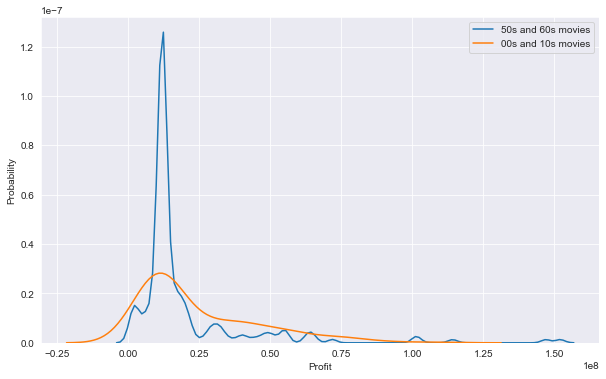

In [48]:
plt.figure(figsize=(10,6))
sns.distplot(fifth_movies_sample, label='50s and 60s movies', hist= False)
sns.distplot(now_movies_sample, label='00s and 10s movies', hist=False)

plt.xlabel('Profit')
plt.ylabel('Probability')

#### Difference between distribution means

In [49]:
diff_means = np.mean(fifth_movies_sample) - np.mean(now_movies_sample)
print("The difference between means is {}".format(diff_means))

The difference between means is -4438318.389983118


#### Welch T-statistic

In [50]:
# importnting welch_t from our .py file
from hyp_testing_functions import welch_t

In [51]:
welch_t_test = welch_t(fifth_movies_sample, now_movies_sample)
print("Welch t-statistic is {}".format(welch_t_test))

Welch t-statistic is 2.0007400942295837


#### Visualising Welch T-test

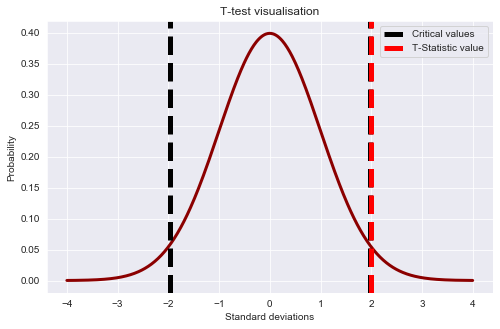

In [52]:
visualize_t(welch_t_test, n_fifth, n_now)

#### Getting the p-value 

In [53]:
# importnting p-value from our .py file
# from hyp_testing_functions import p_value_

In [54]:
## for now we leave it written here 


def p_value_(a, b, two_sided=True):

    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p

In [55]:
# p_value(fifth_movies_sample, now_movies_sample)

In [56]:
stats.ttest_ind(fifth_movies_sample, now_movies_sample)

Ttest_indResult(statistic=-2.0007400942295837, pvalue=0.0461350939784485)

#### Cohen's d test

In [57]:
Cohen_d( fifth_movies_sample, now_movies_sample)

-0.2058139326287308

### Romance movies require different budget than action movies 

In [58]:
rom_movies = list((data_for_ht[(data_for_ht['genre_bis'] == "Romance")]['budget_adjusted']))
act_movies = list((data_for_ht[(data_for_ht['genre_bis']== "Action")]['budget_adjusted']))

#### Getting 2 samples of equal size 

In [59]:
print(len(rom_movies), len(act_movies))

829 1218


In [60]:
rom_movies_sample = random.sample(rom_movies, 829)
act_movies_sample = random.sample(act_movies, 829)

#### Variance and mean of the samples 

In [61]:
print("The variance for the movies on 50s/60s is: {}".format(np.var(rom_movies_sample)))
print("The std for the movies on 50s/60s is: {}".format(np.std(rom_movies_sample)))
print("The mean for the movies on 50s/60s is: {}".format(np.mean(rom_movies_sample)))

print('===============')

print("The variance for the movies nowadays is: {}".format(np.var(act_movies_sample)))
print("The std for the movies on nowadays is: {}".format(np.std(act_movies_sample)))
print("The mean for the movies on nowadays is: {}".format(np.mean(act_movies_sample)))



The variance for the movies on 50s/60s is: 131443187347636.23
The std for the movies on 50s/60s is: 11464867.524207868
The mean for the movies on 50s/60s is: 15246935.194475973
The variance for the movies nowadays is: 653032296130528.8
The std for the movies on nowadays is: 25554496.59317375
The mean for the movies on nowadays is: 31721780.86823388


#### Normality test for samples 

In [62]:
stats.normaltest(rom_movies_sample)

NormaltestResult(statistic=601.7008607987648, pvalue=2.1994707931014913e-131)

In [63]:
stats.normaltest(act_movies_sample)

NormaltestResult(statistic=195.77572004429845, pvalue=3.07498178171294e-43)

#### Plotting the distribution for both samples

Text(0, 0.5, 'Probability')

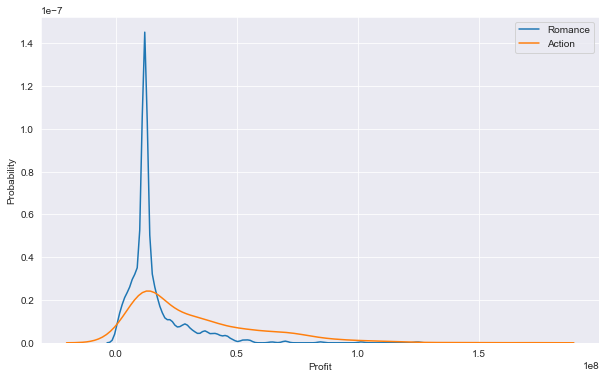

In [64]:
plt.figure(figsize=(10,6))
sns.distplot(rom_movies_sample, label='Romance', hist= False)
sns.distplot(act_movies_sample, label='Action', hist=False)

plt.xlabel('Profit')
plt.ylabel('Probability')

#### Difference between distribution means

In [65]:
diff_means = np.mean(rom_movies_sample) - np.mean(act_movies_sample)
print("The difference between means is {}".format(diff_means))

The difference between means is -16474845.673757905


#### T-statistic

In [66]:
## Importing function from .py file where we stored them 
from hyp_testing_functions import pooled_variance, tstatistic, welch_t
from ht_visualizations import visualize_t
 

In [67]:

t_stat = tstatistic(rom_movies_sample, act_movies_sample)
print("T-Statistic is: {}".format(t_stat))

T-Statistic is: -16.935925422666696


In [68]:
import scipy.stats
# import stats.t
from scipy import stats

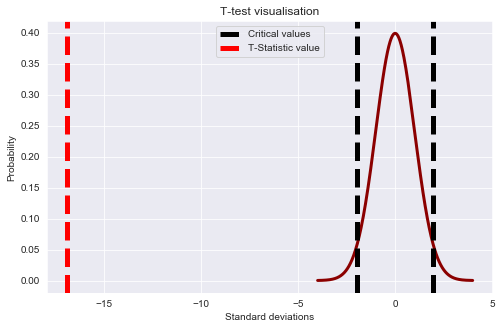

In [69]:

def visualize_t(t_stat, n_control, n_experimental):
    from matplotlib import pyplot as plt 

    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()

    xs = np.linspace(4, -4, 500)

    # use stats.t.ppf to get critical value. For alpha = 0.05 and two tailed test
    crit = stats.t.ppf(1-0.025, (n_control+n_experimental-2))
    
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(crit, color='black', linestyle='--', lw=5, label='Critical values')
    ax.axvline(-crit, color='black', linestyle='--', lw=5)
    ax.axvline(t_stat, color='red', linestyle='--', lw=5, label="T-Statistic value")
    
    plt.title('T-test visualisation')
    plt.legend(loc='best')
    plt.xlabel('Standard deviations')
    plt.ylabel('Probability')
    plt.show()
    return None
n_fifth = len(rom_movies_sample)
n_now = len(act_movies_sample)
visualize_t(t_stat, n_fifth, n_now)



#### Getting p-value

In [70]:
# lower_tail = stats.t.cdf(-t_stat, (890+890-2), 0, 1)
# # Upper tail comulative density function returns area under upper tail curve
# upper_tail = 1. - stats.t.cdf(t_stat, (890+890-2), 0, 1)

# p_value = lower_tail+upper_tail
# print(p_value)

In [71]:
stats.ttest_ind(rom_movies_sample, act_movies_sample)

Ttest_indResult(statistic=-16.9257076688421, pvalue=2.1344167428400686e-59)

#### Cohen's d test

In [72]:
def Cohen_d(group1, group2):


    diff = np.mean(group1) - np.mean(group2)

    n1, n2 = len(group1), len(group2)
    var1 = np.var(group1)
    var2 = np.var(group2)

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [73]:
Cohen_d( rom_movies_sample, act_movies_sample)

-0.8318531493333409

### Romance movies make different profit than action movies

In [74]:
rom_movies = list((data_for_ht[(data_for_ht['genre_bis'] == "Romance")]['profit_adjusted']))
act_movies = list((data_for_ht[(data_for_ht['genre_bis']== "Action")]['profit_adjusted']))

#### Getting 2 samples of equal size 

In [75]:
print(len(rom_movies), len(act_movies))

829 1218


In [76]:
np.random.seed(0)
rom_movies_sample = random.sample(rom_movies, 829)
act_movies_sample = random.sample(act_movies, 829)

#### Variance and mean of the samples 

In [77]:
print("The variance for the movies on 50s/60s is: {}".format(np.var(rom_movies_sample)))
print("The std for the movies on 50s/60s is: {}".format(np.std(rom_movies_sample)))
print("The mean for the movies on 50s/60s is: {}".format(np.mean(rom_movies_sample)))

print('===============')

print("The variance for the movies nowadays is: {}".format(np.var(act_movies_sample)))
print("The std for the movies on nowadays is: {}".format(np.std(act_movies_sample)))
print("The mean for the movies on nowadays is: {}".format(np.mean(act_movies_sample)))



The variance for the movies on 50s/60s is: 1217701722723433.2
The std for the movies on 50s/60s is: 34895583.14061298
The mean for the movies on 50s/60s is: 19572339.63780084
The variance for the movies nowadays is: 2303467636309352.0
The std for the movies on nowadays is: 47994454.22451798
The mean for the movies on nowadays is: 15225450.133056397


#### Normality test for samples 

In [78]:
stats.normaltest(rom_movies_sample)

NormaltestResult(statistic=700.9574466221782, pvalue=6.152114949942319e-153)

In [79]:
stats.normaltest(act_movies_sample)

NormaltestResult(statistic=678.1410338903099, pvalue=5.540456056084024e-148)

#### Plotting the distribution for both samples

Text(0, 0.5, 'Probability')

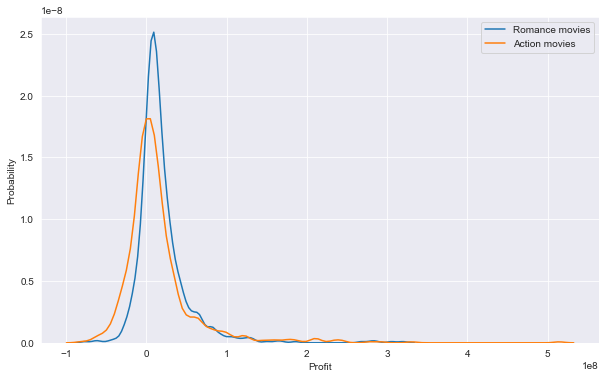

In [80]:
plt.figure(figsize=(10,6))
sns.distplot(rom_movies_sample, label='Romance movies', hist= False)
sns.distplot(act_movies_sample, label='Action movies', hist=False)

plt.xlabel('Profit')
plt.ylabel('Probability')

#### Difference between distribution means

In [81]:
diff_means = np.mean(rom_movies_sample) - np.mean(act_movies_sample)
print("The difference between means is {}".format(diff_means))

The difference between means is 4346889.504744442


#### T-statistic

In [82]:
## Importing function from .py file where we stored them 
from hyp_testing_functions import pooled_variance, tstatistic, welch_t
from ht_visualizations import visualize_t
 

In [83]:

t_stat = welch_t(rom_movies_sample, act_movies_sample)
print("T-Statistic is: {}".format(t_stat))

T-Statistic is: 2.107901496749861


In [84]:
import scipy.stats
# import stats.t
from scipy import stats

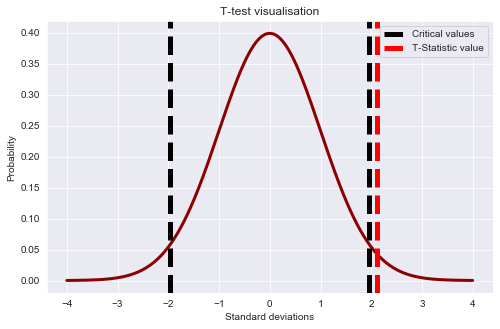

In [85]:

def visualize_t(t_stat, n_control, n_experimental):
    from matplotlib import pyplot as plt 

    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()

    xs = np.linspace(4, -4, 500)

    # use stats.t.ppf to get critical value. For alpha = 0.05 and two tailed test
    crit = stats.t.ppf(1-0.025, (n_control+n_experimental-2))
    
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(crit, color='black', linestyle='--', lw=5, label='Critical values')
    ax.axvline(-crit, color='black', linestyle='--', lw=5)
    ax.axvline(t_stat, color='red', linestyle='--', lw=5, label="T-Statistic value")
    
    plt.title('T-test visualisation')
    plt.legend(loc='best')
    plt.xlabel('Standard deviations')
    plt.ylabel('Probability')
    plt.show()
    return None
n_fifth = len(rom_movies_sample)
n_now = len(act_movies_sample)
visualize_t(t_stat, n_fifth, n_now)



#### Getting p-value

In [86]:
# lower_tail = stats.t.cdf(-t_stat, (890+890-2), 0, 1)
# # Upper tail comulative density function returns area under upper tail curve
# upper_tail = 1. - stats.t.cdf(t_stat, (890+890-2), 0, 1)

# p_value = lower_tail+upper_tail
# print(p_value)

In [87]:
stats.ttest_ind(rom_movies_sample, act_movies_sample)

Ttest_indResult(statistic=2.107901496749861, pvalue=0.035189440849543875)

#### Cohen's d test

In [88]:
def Cohen_d(group1, group2):


    diff = np.mean(group1) - np.mean(group2)

    n1, n2 = len(group1), len(group2)
    var1 = np.var(group1)
    var2 = np.var(group2)

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [89]:
Cohen_d( rom_movies_sample, act_movies_sample)

0.10359770668754499

# Findings and applications

**Hypothesis 1**

We did find out that there is statistical significance between the profit of the romance and action movies but based on our tests there is little to no practical significance. We would advise the movie production company not to make their decisions based on the profit of movies in those genres.

**Hypothesis 2**

We did find a statistical significance and practical significance when considering the budget of both movie genres. Action movies require more budget than romance movies so we were able to reject our null hypothesis in that instance.

Judging by the findings above romance movie profits and action movie profits don't seem to have much of a difference but action movie budgets are higher..if the movie company production is interested in making more profit in the box office whilst spending less on budget..we would recommend "carving a niche as a romance genre movie production company"

**Hypothesis 3**

We did find that the budget for the movies in the 50s and 60s compared to the 2000s 2010s when adjusted for inflation had statistical significance but little to no practical significance. We would advise the movie production company not make their decision based on this metric

**Hypothesis 4**

We did find that the profit of movies in the 50 and 60s compared to the 2000s and 2010s made higher profit when adjusted for inflation. As there was both statistical and practical significance. We can attribute to the case that te era saw the rise of films featuring darker plot lines and characters played by “edgier” stars like James Dean, Marlon Brando, Ava Gardner, and Marilyn Monroe and also the rise of pop culture with Hollywood companies adapting to the times by shifting from theaterical release of movies to TV sets

# Limitations

- We would have liked to delve more into the reason why 50s and 60s movies made more profit than nowadays if we had more data pertaining to those years.


- We would have liked to look at more movie genres and compare profits and budgets, especially marketing budget if we had the data, so the movie companies can make better decisions on how to spend their budget efficiently to garner the most profits

# Next steps

The next step for our data science company is to gather more data about the movie industry and investigate whether there is a difference in profits and gross revenue at the box office when casting top rated movie actor/director or mediocre rated actor/director for your movie.